In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import default_data_collator
from datasets import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)

In [2]:
# set default device
torch.cuda.set_device(7)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t12_35M_UR50D", device_map='cuda:3')
# remove model.esm.contact_head from model
del model.esm.contact_head

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t12_35M_UR50D/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t12_35M_UR50D/resolve/main/config.json HTTP/1.1" 200 0


In [4]:
# process fasta
def read_fasta(fasta_file):
    with open(fasta_file) as f:
        lines = f.readlines()
    seqs = []
    for line in lines:
        if line[0] == '>':
            if seqs:
                seqs[-1] = ''.join(seqs[-1])
            seqs.append([])
        else:
            seqs[-1].append(line.strip())
    seqs[-1] = ''.join(seqs[-1])
    return seqs

In [5]:
seqs = read_fasta('partial.fasta')

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cadegord/miniconda3/envs/bio-if/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cadegord/miniconda3/envs/bio-if/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cadegord/miniconda3/envs

Text(0, 0.5, 'Frequency')

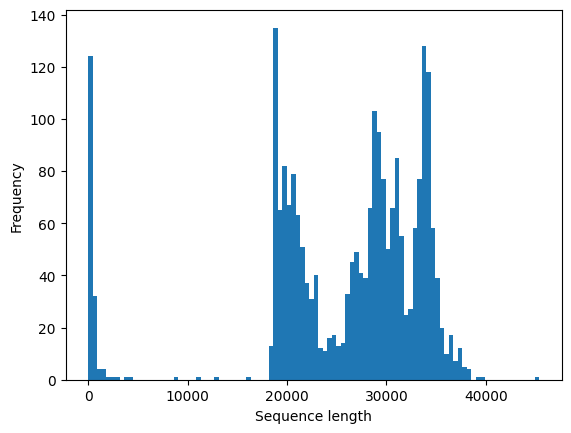

In [6]:
plt.hist([len(seq) for seq in seqs], bins=100)
plt.xlabel('Sequence length')
plt.ylabel('Frequency')

In [7]:
ds = Dataset.from_dict({'seq': [seq[:256] for seq in seqs]})
ds = ds.map(lambda x: tokenizer(x['seq'], padding='max_length', truncation=True, max_length=256, return_tensors='pt'), batched=True)

Map:   0%|          | 0/2331 [00:00<?, ? examples/s]

In [8]:
ds

Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 2331
})

In [9]:
from kronfluence import Analyzer, prepare_model
from kronfluence.task import Task
from kronfluence.utils.dataset import DataLoaderKwargs

In [10]:
from typing import Dict, Optional

BATCH_TYPE = Dict[str, torch.Tensor]

class MLMTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits

        if not sample:
            return (F.cross_entropy(logits.transpose(1,2), batch["input_ids"], reduction='none') * batch["attention_mask"]).sum()
        with torch.no_grad():
            sampled_labels = torch.distributions.Categorical(logits=logits).sample()
        return (F.cross_entropy(logits.transpose(1,2), sampled_labels.detach(), reduction='none') * batch["attention_mask"]).sum()

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py.
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits

        labels = batch["input_ids"]
        logits_correct = logits.view(-1, logits.size(-1))
        logits_correct = logits_correct[torch.arange(len(labels.view(-1))), labels.view(-1)]
        logits_correct = logits_correct.view(*labels.size())

        cloned_logits = logits.clone()
        cloned_logits = cloned_logits.view(-1, cloned_logits.size(-1))
        cloned_logits[torch.arange(len(labels.view(-1))), labels.view(-1)] = float("-inf")
        cloned_logits = cloned_logits.view(*logits.size())

        margins = logits_correct - cloned_logits.logsumexp(dim=-1)
        margins = margins * batch["attention_mask"]
        return -margins.sum()

    def get_attention_mask(self, batch: BATCH_TYPE) -> Optional[torch.Tensor]:
        return batch["attention_mask"]

In [11]:
task = MLMTask()
model = prepare_model(model, task)

In [12]:
analyzer = Analyzer(
    analysis_name=f"esm2_t12_35M_UR50D_benchmarking",
    task=task,
    model=model,
    cpu=False,
)
dataloader_kwargs = DataLoaderKwargs(collate_fn=default_data_collator)
analyzer.set_dataloader_kwargs(dataloader_kwargs)

INFO:kronfluence.computer.computer:Tracking modules with names: ['esm.encoder.layer.0.attention.self.query', 'esm.encoder.layer.0.attention.self.key', 'esm.encoder.layer.0.attention.self.value', 'esm.encoder.layer.0.attention.output.dense', 'esm.encoder.layer.0.intermediate.dense', 'esm.encoder.layer.0.output.dense', 'esm.encoder.layer.1.attention.self.query', 'esm.encoder.layer.1.attention.self.key', 'esm.encoder.layer.1.attention.self.value', 'esm.encoder.layer.1.attention.output.dense', 'esm.encoder.layer.1.intermediate.dense', 'esm.encoder.layer.1.output.dense', 'esm.encoder.layer.2.attention.self.query', 'esm.encoder.layer.2.attention.self.key', 'esm.encoder.layer.2.attention.self.value', 'esm.encoder.layer.2.attention.output.dense', 'esm.encoder.layer.2.intermediate.dense', 'esm.encoder.layer.2.output.dense', 'esm.encoder.layer.3.attention.self.query', 'esm.encoder.layer.3.attention.self.key', 'esm.encoder.layer.3.attention.self.value', 'esm.encoder.layer.3.attention.output.dense

In [13]:
analyzer.fit_all_factors(
    factors_name="esm2_t12_35M_UR50D_benchmarking",
    dataset=Dataset.from_dict(ds[:256]),
    # dataset=ds,
    per_device_batch_size=None,
    overwrite_output_dir=False,
    initial_per_device_batch_size_attempt=512,
)

DEBUG:kronfluence.computer.computer:Fitting covariance matrices with parameters: {'self': <kronfluence.analyzer.Analyzer object at 0x7f25e716d9a0>, 'factors_name': 'esm2_t12_35M_UR50D_benchmarking', 'dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'per_device_batch_size': None, 'initial_per_device_batch_size_attempt': 512, 'dataloader_kwargs': None, 'factor_args': None, 'target_data_partitions': None, 'target_module_partitions': None, 'overwrite_output_dir': False}
INFO:kronfluence.computer.computer:Found existing covariance matrices at `/home/cadegord/projects/bio-if/private/esm2-if/analyses/esm2_t12_35M_UR50D_benchmarking/factors_esm2_t12_35M_UR50D_benchmarking`. Skipping.
DEBUG:kronfluence.computer.computer:Performing Eigendecomposition with parameters: {'self': <kronfluence.analyzer.Analyzer object at 0x7f25e716d9a0>, 'factors_name': 'esm2_t12_35M_UR50D_benchmarking', 'factor_args': None, 'overwrite_output_dir': False, 'load_from_fact

In [14]:
analyzer.compute_pairwise_scores(
    scores_name="esm2_t12_35M_UR50D_benchmarking",
    factors_name="esm2_t12_35M_UR50D_benchmarking",
    overwrite_output_dir=True,
    query_dataset=Dataset.from_dict(ds[:256]),
    train_dataset=Dataset.from_dict(ds[:256]),
    per_device_query_batch_size=16,
)

DEBUG:kronfluence.computer.computer:Computing pairwise scores with parameters: {'self': <kronfluence.analyzer.Analyzer object at 0x7f25e716d9a0>, 'scores_name': 'esm2_t12_35M_UR50D_benchmarking', 'factors_name': 'esm2_t12_35M_UR50D_benchmarking', 'query_dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'train_dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'per_device_query_batch_size': 16, 'per_device_train_batch_size': None, 'initial_per_device_train_batch_size_attempt': 4096, 'query_indices': None, 'train_indices': None, 'dataloader_kwargs': None, 'score_args': None, 'target_data_partitions': None, 'target_module_partitions': None, 'overwrite_output_dir': True}
INFO:kronfluence.computer.computer:Score arguments not provided. Using the default configuration: ScoreArguments(damping=None, immediate_gradient_removal=False, cached_activation_cpu_offload=False, distributed_sync_steps=1000, data_p

In [9]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t30_150M_UR50D", device_map='cuda:7')
# remove model.esm.contact_head from model
del model.esm.contact_head

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139672161896912 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/3f0d47e841e1cb75257aeaf76d156802899a217e.lock
DEBUG:filelock:Lock 139672161896912 acquired on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/3f0d47e841e1cb75257aeaf76d156802899a217e.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /facebook/esm2_t30_150M_UR50D/resolve/main/tokenizer_config.json HTTP/1.1" 200 95


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139672161896912 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/3f0d47e841e1cb75257aeaf76d156802899a217e.lock
DEBUG:filelock:Lock 139672161896912 released on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/3f0d47e841e1cb75257aeaf76d156802899a217e.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139665957118880 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/6b946952cc35537226f07fd70957ee2f848880d2.lock
DEBUG:filelock:Lock 139665957118880 acquired on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/6b946952cc35537226f07fd70957ee2f848880d2.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /facebook/esm2_t30_150M_UR50D/resolve/main/vocab.txt HTTP/1.1" 200 93


vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139665957118880 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/6b946952cc35537226f07fd70957ee2f848880d2.lock
DEBUG:filelock:Lock 139665957118880 released on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/6b946952cc35537226f07fd70957ee2f848880d2.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139673392458960 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/ba0f9b53dbbf27934f7555e5d31e37bdea9317f1.lock
DEBUG:filelock:Lock 139673392458960 acquired on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/ba0f9b53dbbf27934f7555e5d31e

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139673392458960 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/ba0f9b53dbbf27934f7555e5d31e37bdea9317f1.lock
DEBUG:filelock:Lock 139673392458960 released on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/ba0f9b53dbbf27934f7555e5d31e37bdea9317f1.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/tokenizer.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139665957038160 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/52e04179e6fbad6663a94ea5cc44f09d764c5cd4.lock
DEBUG:filelock:Lock 139665957038160 acquired on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/52e04179e6fbad6663a94ea5cc44f09d764c5cd4.lo

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139665957038160 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/52e04179e6fbad6663a94ea5cc44f09d764c5cd4.lock
DEBUG:filelock:Lock 139665957038160 released on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/52e04179e6fbad6663a94ea5cc44f09d764c5cd4.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t30_150M_UR50D/resolve/main/model.safetensors HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 139672162485872 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/c3f1da8aea53bddd32c246c86168c23b9fd72341fb9db9a94436f855f5053566.lock
DEBUG:filelock:Lock 139672162485872 acquired on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/c3f1da8aea53bddd32c246c86168c23b9fd72341fb9db9a94436f855f5053566.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): cdn-lfs.hugging

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139672162485872 on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/c3f1da8aea53bddd32c246c86168c23b9fd72341fb9db9a94436f855f5053566.lock
DEBUG:filelock:Lock 139672162485872 released on /home/cadegord/.cache/huggingface/hub/.locks/models--facebook--esm2_t30_150M_UR50D/c3f1da8aea53bddd32c246c86168c23b9fd72341fb9db9a94436f855f5053566.lock


In [17]:
task = MLMTask()
model = prepare_model(model, task)

In [18]:
analyzer = Analyzer(
    analysis_name=f"esm2_t30_150M_UR50D_benchmarking",
    task=task,
    model=model,
    cpu=False,
)
dataloader_kwargs = DataLoaderKwargs(collate_fn=default_data_collator)
analyzer.set_dataloader_kwargs(dataloader_kwargs)

INFO:kronfluence.computer.computer:Tracking modules with names: ['esm.encoder.layer.0.attention.self.query', 'esm.encoder.layer.0.attention.self.key', 'esm.encoder.layer.0.attention.self.value', 'esm.encoder.layer.0.attention.output.dense', 'esm.encoder.layer.0.intermediate.dense', 'esm.encoder.layer.0.output.dense', 'esm.encoder.layer.1.attention.self.query', 'esm.encoder.layer.1.attention.self.key', 'esm.encoder.layer.1.attention.self.value', 'esm.encoder.layer.1.attention.output.dense', 'esm.encoder.layer.1.intermediate.dense', 'esm.encoder.layer.1.output.dense', 'esm.encoder.layer.2.attention.self.query', 'esm.encoder.layer.2.attention.self.key', 'esm.encoder.layer.2.attention.self.value', 'esm.encoder.layer.2.attention.output.dense', 'esm.encoder.layer.2.intermediate.dense', 'esm.encoder.layer.2.output.dense', 'esm.encoder.layer.3.attention.self.query', 'esm.encoder.layer.3.attention.self.key', 'esm.encoder.layer.3.attention.self.value', 'esm.encoder.layer.3.attention.output.dense

In [19]:
analyzer.fit_all_factors(
    factors_name="esm2_t30_150M_UR50D_benchmarking",
    dataset=Dataset.from_dict(ds[:256]),
    # dataset=ds,
    per_device_batch_size=None,
    overwrite_output_dir=False,
    initial_per_device_batch_size_attempt=512,
)

DEBUG:kronfluence.computer.computer:Fitting covariance matrices with parameters: {'self': <kronfluence.analyzer.Analyzer object at 0x7f0681ed5a60>, 'factors_name': 'esm2_t30_150M_UR50D_benchmarking', 'dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'per_device_batch_size': None, 'initial_per_device_batch_size_attempt': 512, 'dataloader_kwargs': None, 'factor_args': None, 'target_data_partitions': None, 'target_module_partitions': None, 'overwrite_output_dir': False}
INFO:kronfluence.computer.computer:Factor arguments not provided. Using the default configuration: FactorArguments(strategy='ekfac', use_empirical_fisher=False, immediate_gradient_removal=False, ignore_bias=False, distributed_sync_steps=1000, covariance_max_examples=100000, covariance_data_partition_size=1, covariance_module_partition_size=1, activation_covariance_dtype=torch.float32, gradient_covariance_dtype=torch.float32, eigendecomposition_dtype=torch.float64, lambda_max_e

In [21]:
analyzer.compute_pairwise_scores(
    scores_name="esm2_t30_150M_UR50D_benchmarking",
    factors_name="esm2_t30_150M_UR50D_benchmarking",
    overwrite_output_dir=True,
    query_dataset=Dataset.from_dict(ds[:256]),
    train_dataset=Dataset.from_dict(ds[:256]),
    per_device_query_batch_size=8,
)

DEBUG:kronfluence.computer.computer:Computing pairwise scores with parameters: {'self': <kronfluence.analyzer.Analyzer object at 0x7f0681ed5a60>, 'scores_name': 'esm2_t30_150M_UR50D_benchmarking', 'factors_name': 'esm2_t30_150M_UR50D_benchmarking', 'query_dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'train_dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'per_device_query_batch_size': 8, 'per_device_train_batch_size': None, 'initial_per_device_train_batch_size_attempt': 4096, 'query_indices': None, 'train_indices': None, 'dataloader_kwargs': None, 'score_args': None, 'target_data_partitions': None, 'target_module_partitions': None, 'overwrite_output_dir': True}
INFO:kronfluence.computer.computer:Score arguments not provided. Using the default configuration: ScoreArguments(damping=None, immediate_gradient_removal=False, cached_activation_cpu_offload=False, distributed_sync_steps=1000, data_

In [3]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D", device_map='cuda:7')
# remove model.esm.contact_head from model
del model.esm.contact_head

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t33_650M_UR50D/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/esm2_t33_650M_UR50D/resolve/main/config.json HTTP/1.1" 200 0


In [11]:
task = MLMTask()
model = prepare_model(model, task)

In [12]:
analyzer = Analyzer(
    analysis_name=f"esm2_t33_650M_UR50D_benchmarking",
    task=task,
    model=model,
    cpu=False,
)
dataloader_kwargs = DataLoaderKwargs(collate_fn=default_data_collator)
analyzer.set_dataloader_kwargs(dataloader_kwargs)

INFO:kronfluence.computer.computer:Tracking modules with names: ['esm.encoder.layer.0.attention.self.query', 'esm.encoder.layer.0.attention.self.key', 'esm.encoder.layer.0.attention.self.value', 'esm.encoder.layer.0.attention.output.dense', 'esm.encoder.layer.0.intermediate.dense', 'esm.encoder.layer.0.output.dense', 'esm.encoder.layer.1.attention.self.query', 'esm.encoder.layer.1.attention.self.key', 'esm.encoder.layer.1.attention.self.value', 'esm.encoder.layer.1.attention.output.dense', 'esm.encoder.layer.1.intermediate.dense', 'esm.encoder.layer.1.output.dense', 'esm.encoder.layer.2.attention.self.query', 'esm.encoder.layer.2.attention.self.key', 'esm.encoder.layer.2.attention.self.value', 'esm.encoder.layer.2.attention.output.dense', 'esm.encoder.layer.2.intermediate.dense', 'esm.encoder.layer.2.output.dense', 'esm.encoder.layer.3.attention.self.query', 'esm.encoder.layer.3.attention.self.key', 'esm.encoder.layer.3.attention.self.value', 'esm.encoder.layer.3.attention.output.dense

In [13]:
analyzer.fit_all_factors(
    factors_name="esm2_t33_650M_UR50D_benchmarking",
    dataset=Dataset.from_dict(ds[:256]),
    # dataset=ds,
    per_device_batch_size=None,
    overwrite_output_dir=False,
    initial_per_device_batch_size_attempt=2,
)

DEBUG:kronfluence.computer.computer:Fitting covariance matrices with parameters: {'self': <kronfluence.analyzer.Analyzer object at 0x7f1a31e63dc0>, 'factors_name': 'esm2_t33_650M_UR50D_benchmarking', 'dataset': Dataset({
    features: ['seq', 'input_ids', 'attention_mask'],
    num_rows: 256
}), 'per_device_batch_size': None, 'initial_per_device_batch_size_attempt': 2, 'dataloader_kwargs': None, 'factor_args': None, 'target_data_partitions': None, 'target_module_partitions': None, 'overwrite_output_dir': False}
INFO:kronfluence.computer.computer:Factor arguments not provided. Using the default configuration: FactorArguments(strategy='ekfac', use_empirical_fisher=False, immediate_gradient_removal=False, ignore_bias=False, distributed_sync_steps=1000, covariance_max_examples=100000, covariance_data_partition_size=1, covariance_module_partition_size=1, activation_covariance_dtype=torch.float32, gradient_covariance_dtype=torch.float32, eigendecomposition_dtype=torch.float64, lambda_max_exa

RuntimeError: No executable batch size found, reached zero.